# Read All Dataset CSV

In [109]:
import os
import csv
import pandas as pd
import numpy as np

In [110]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [111]:
dataset_names=[]
X_trains=[]
y_trains=[]
X_tests=[]

for folder_name in os.listdir("./Competition_data"):
    
    x_train = pd.read_csv(f"./Competition_data/{folder_name}/X_train.csv",header=0)
    y_train = pd.read_csv(f"./Competition_data/{folder_name}/y_train.csv",header=0)
    x_test = pd.read_csv(f"./Competition_data/{folder_name}/X_test.csv",header=0)  
    
    # Initialize Encoder
    label_encoder = LabelEncoder()
    OneHotEncoder_encoder = OneHotEncoder()
    standard_encoder = StandardScaler()
    minmax_encoder = MinMaxScaler()

    # seperate the categorical columns and numerical columns
    numerical_columns = []
    categorical_columns = []
    for i in x_train.columns:
        if x_train[i].dtype == 'float64':
            numerical_columns.append(i)
        else:
            categorical_columns.append(i)
            
    # copy to avoid changing the original data
    X_train_encoded = x_train.copy()
    X_test_encoded = x_test.copy()


    for col in categorical_columns:
        # Fit the one hot encoder on the combined data of train and test to avoid unseen labels
        combined_data = pd.concat([x_train[col], x_test[col]], axis=0)
        OneHotEncoder_encoder.fit(combined_data.values.reshape(-1, 1))

        # Transform the train and test data
        train_encoded = OneHotEncoder_encoder.transform(x_train[col].values.reshape(-1, 1)).toarray()
        test_encoded = OneHotEncoder_encoder.transform(x_test[col].values.reshape(-1, 1)).toarray()

        # Create new column names for the one hot encoded columns
        train_encoded_df = pd.DataFrame(train_encoded, columns=[f"{col}_{int(i)}" for i in range(train_encoded.shape[1])])
        test_encoded_df = pd.DataFrame(test_encoded, columns=[f"{col}_{int(i)}" for i in range(test_encoded.shape[1])])

        # Concatenate the new one hot encoded columns to the original dataframe
        X_train_encoded = pd.concat([X_train_encoded, train_encoded_df], axis=1)
        X_test_encoded = pd.concat([X_test_encoded, test_encoded_df], axis=1)

        # Drop the original categorical columns
        X_train_encoded.drop(columns=[col], inplace=True)
        X_test_encoded.drop(columns=[col], inplace=True)

    # for col in categorical_columns:
    #     # Fit the label encoder on the combined data of train and test to avoid unseen labels
    #     combined_data = pd.concat([x_train[col], x_test[col]], axis=0)
    #     label_encoder.fit(combined_data)

    #     X_train_encoded[col] = label_encoder.transform(x_train[col])
    #     X_test_encoded[col] = label_encoder.transform(x_test[col])

    # #  == apply standard scaler to numerical columns == ##
    # for col in numerical_columns:
    #     combined_data = pd.concat([x_train[col], x_test[col]], axis=0)
    #     standard_encoder.fit(combined_data.values.reshape(-1, 1))

    #     X_train_encoded[col] = standard_encoder.fit_transform(x_train[col].values.reshape(-1, 1))
    #     X_test_encoded[col] = standard_encoder.transform(x_test[col].values.reshape(-1, 1))

    ##  == apply minmax scaler to numerical columns cuz we use XGBOOST and RF== ##
    for col in numerical_columns:
        combined_data = pd.concat([x_train[col], x_test[col]], axis=0)
        minmax_encoder.fit(combined_data.values.reshape(-1, 1))

        X_train_encoded[col] = minmax_encoder.transform(x_train[col].values.reshape(-1, 1))
        X_test_encoded[col] = minmax_encoder.transform(x_test[col].values.reshape(-1, 1))

    dataset_names.append(folder_name)
    X_trains.append(X_train_encoded)
    y_trains.append(y_train)
    X_tests.append(X_test_encoded)

In [112]:
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import  VarianceThreshold
from sklearn.ensemble import RandomForestClassifier

In [113]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [114]:
print(f"Before PCA, X_train shape: {X_trains[0].shape}")
print(f"Before PCA, y_train shape: {y_trains[0].shape}")

# Step 1: 切分資料
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_trains[0], y_trains[0], test_size=0.2, random_state=42)

# 確保切分後的樣本數一致
print(f"After train_test_split, X_train_part shape: {X_train_part.shape}")
print(f"After train_test_split, y_train_part shape: {y_train_part.shape}")

# Step 2: PCA 降維
pca = PCA(n_components=0.95)  # 保留 95% 的數據變異
X_train_pca = pca.fit_transform(X_train_part)
X_valid_pca = pca.transform(X_valid)  # 注意這裡是 transform，不是 fit_transform
X_test_pca = pca.transform(X_valid)

# 確保降維後樣本數保持一致
print(f"After PCA, X_train_pca shape: {X_train_pca.shape}")
print(f"After PCA, X_valid_pca shape: {X_valid_pca.shape}")
print(f"y_train shape: {y_train_part.shape}")

# Step 3: Mutual Information 特徵選擇
mi_scores = mutual_info_classif(X_train_pca, y_train_part.values.ravel())  # 計算互信息分數
mi_threshold = np.mean(mi_scores)  # 使用平均值作為閾值
selected_mi_features = mi_scores > mi_threshold

# 保留選中的特徵
X_train_mi = X_train_pca[:, selected_mi_features]
X_valid_mi = X_valid_pca[:, selected_mi_features]  # 記得對驗證集也做相同的選擇
X_test_mi = X_test_pca[:, selected_mi_features]

# 確保選擇後特徵數量正確
print(f"互信息篩選後的特徵數量: {X_train_mi.shape[1]}")

# Step 4: LightGBM 嵌入式方法
lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
lgb_model.fit(X_train_mi, y_train_part.values.ravel())  # 訓練模型

# 使用特徵重要性進行篩選
feature_importances = lgb_model.feature_importances_
importance_threshold = np.mean(feature_importances)  # 使用平均值作為閾值
selected_lgb_features = feature_importances > importance_threshold

X_train_final = X_train_mi[:, selected_lgb_features]
X_valid_final = X_valid_mi[:, selected_lgb_features]  # 記得對驗證集也進行相同操作
X_test_final = X_test_mi[:, selected_lgb_features]

# 確保最終特徵數量
print(f"LightGBM 篩選後的特徵數量: {X_train_final.shape[1]}")

# Step 5: 將最終特徵轉回 DataFrame
X_train_final_df = pd.DataFrame(X_train_final, columns=[f"Feature_{i+1}" for i in range(X_train_final.shape[1])])
X_valid_final_df = pd.DataFrame(X_valid_final, columns=[f"Feature_{i+1}" for i in range(X_valid_final.shape[1])])
X_test_final_df = pd.DataFrame(X_test_final, columns=[f"Feature_{i+1}" for i in range(X_test_final.shape[1])])

# 更新 X_trains 和 X_tests
# X_trains[0] = X_train_final_df
# X_tests[0] = X_valid_final_df
X_trains[0] = pd.concat([X_train_final_df, X_valid_final_df], axis=0)
X_tests[0] = X_test_final_df

print(f"x_train shape: {X_trains[0].shape}")
print(f"y_train shape: {y_trains[0].shape}")

# 顯示最終的特徵
print(f"Final features in X_train: {X_trains[0].shape}")
print(f"Final features in X_test: {X_tests[0].shape}")


Before PCA, X_train shape: (444, 79)
Before PCA, y_train shape: (444, 1)
After train_test_split, X_train_part shape: (355, 79)
After train_test_split, y_train_part shape: (355, 1)
After PCA, X_train_pca shape: (355, 34)
After PCA, X_valid_pca shape: (89, 34)
y_train shape: (355, 1)
互信息篩選後的特徵數量: 13
[LightGBM] [Info] Number of positive: 109, number of negative: 246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1544
[LightGBM] [Info] Number of data points in the train set: 355, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.307042 -> initscore=-0.813984
[LightGBM] [Info] Start training from score -0.813984
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [115]:
# print(f"Before PCA, X_train shape: {X_trains[0].shape}")
# print(f"Before PCA, y_train shape: {y_trains[0].shape}")

# X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_trains[0], y_trains[0], test_size=0.2, random_state=42)

# # Step 1: PCA 降維
# pca = PCA(n_components=0.95)  # 保留 95% 的數據變異
# X_train_pca = pca.fit_transform(X_train_part)
# X_valid_pca = pca.transform(X_valid)

# print(f"after pca: {X_train_pca.shape[1]}")

# print(f"After PCA, X_train_pca shape: {X_train_pca.shape}")
# print(f"After PCA, y_train shape: {y_trains[0].shape}")

# # Step 2: Mutual Information 特徵選擇
# mi_scores = mutual_info_classif(X_train_pca, y_train_part.values.ravel())  # 計算互信息分數
# mi_threshold = np.mean(mi_scores)  # 使用平均值作為閾值
# selected_mi_features = mi_scores > mi_threshold

# # 保留選中的特徵
# X_train_mi = X_train_pca[:, selected_mi_features]
# X_valid_mi = X_valid_pca[:, selected_mi_features]

# print(f"互信息篩選後的特徵數量: {X_train_mi.shape[1]}")

# # Step 3: 嵌入式方法 LightGBM
# lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
# lgb_model.fit(X_train_mi, y_train_part.values.ravel())  # 訓練模型

# # 使用特徵重要性進行篩選
# feature_importances = lgb_model.feature_importances_
# importance_threshold = np.mean(feature_importances)  # 使用平均值作為閾值
# selected_lgb_features = feature_importances > importance_threshold

# X_train_final = X_train_mi[:, selected_lgb_features]
# X_valid_final = X_valid_mi[:, selected_lgb_features]

# print(f"LightGBM 篩選後的特徵數量: {X_train_final.shape[1]}")

# # Convert the numpy arrays back to DataFrames with the selected feature names
# X_train_final_df = pd.DataFrame(X_train_final, columns=[f"Feature_{i+1}" for i in range(X_train_final.shape[1])])
# X_valid_final_df = pd.DataFrame(X_valid_final, columns=[f"Feature_{i+1}" for i in range(X_valid_final.shape[1])])

# # Update X_trains[0] and X_tests[0] with the new DataFrames
# X_trains[0] = X_train_final_df
# X_tests[0] = X_valid_final_df

# # 顯示最終的特徵
# print(f"Final features in X_train: {X_trains[0].shape}")
# print(f"Final features in X_test: {X_tests[0].shape}")

In [116]:
# ## First: use Filter method to remove features with low variance
# filter = VarianceThreshold()
# X_train_encoded = X_trains[0]
# X_test_encoded = X_tests[0]
# y_train = y_trains[0]   

# # Fit the filter on the train data
# filter.fit(X_train_encoded)

# # Transform the train and test data
# X_train_encoded = filter.transform(X_train_encoded)
# X_test_encoded = filter.transform(X_test_encoded)

# ## Second: use embedded method to select features
# # Initialize the model
# model = RandomForestClassifier(n_estimators=100, random_state=42)

# # Fit the model
# model.fit(X_train_encoded, y_train.values.ravel())

# # Get feature importances
# importances = model.feature_importances_

# # Select features based on importance
# selected_features = importances > np.mean(importances)

# # print("Selected features:", selected_features)

# # Convert the numpy arrays back to DataFrames with the selected feature names
# selected_feature_names = X_trains[0].columns[selected_features]
# X_trains[0] = pd.DataFrame(X_trains[0], columns=selected_feature_names)
# X_tests[0] = pd.DataFrame(X_tests[0], columns=selected_feature_names)

# X_trains[0]

## Data Preprocessing & Feature Engineering

## train test split & build Model
You can select an appropriate model and perform corresponding hyperparameter tuning.

In [117]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier

In [118]:
X_trains[0]

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6
0,-0.357158,0.294746,0.432930,0.696367,-0.038137,-0.062739
1,-0.113929,0.409141,1.026926,-0.457191,0.382758,0.117750
2,-0.335995,0.037153,-0.381586,0.316484,0.810307,0.257436
3,-0.233694,0.811494,-0.308119,-0.168989,0.209999,0.181016
4,0.556720,-0.301286,-0.010348,-0.068873,-0.095157,0.103299
...,...,...,...,...,...,...
84,-0.130561,0.826632,0.057251,0.274762,-0.021231,-0.201547
85,0.156356,-0.680375,-0.388724,-0.122849,0.221522,-0.413392
86,0.297761,0.028347,-0.207498,-0.202274,0.559914,-0.534793
87,-0.102034,0.291292,-0.255958,0.364220,0.391619,-0.343519


In [119]:
print(X_trains[0].shape)
print(y_trains[0].shape)


(444, 6)
(444, 1)


c:\Users\wu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\wu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


0 times finish
AUC: 0.54


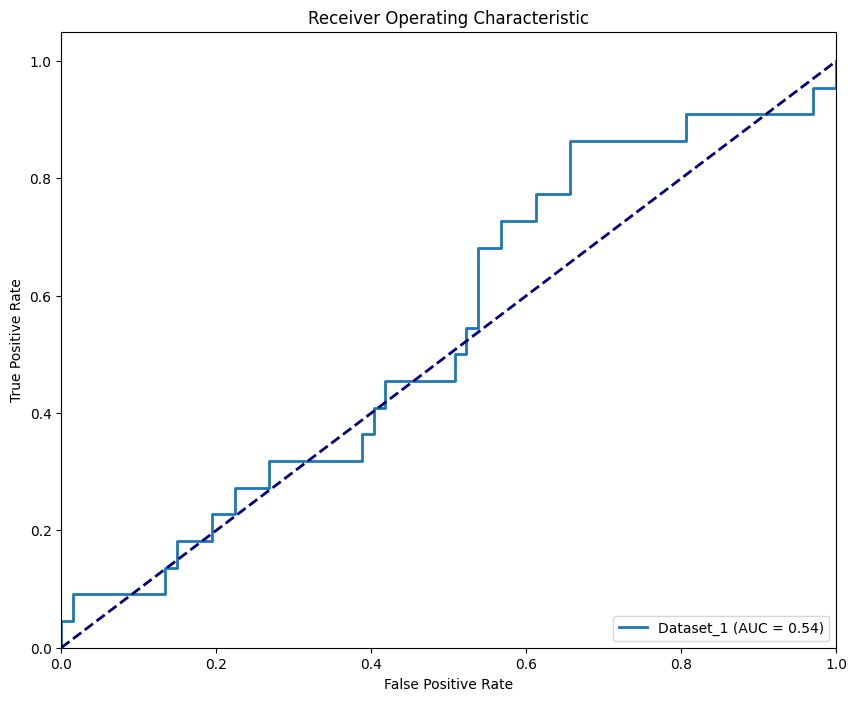

In [120]:
plt.figure(figsize=(10, 8))

X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_trains[0], y_trains[0], test_size=0.2, random_state=42)

##  Boosting first, Bagging second, Stacking third

# 1.Boosting first: Initialize the boosting models
boosting_clf1 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
boosting_clf2 = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
boosting_clf3 = RandomForestClassifier(n_estimators=100, random_state=42)


# 2.Bagging second: use VotingClassifier to combine the boosting models
votin_clf= VotingClassifier(estimators=[
            ('gb1', boosting_clf1),
            ('gb2', boosting_clf2),
            ('gb3', boosting_clf3)],voting='soft', n_jobs=-1)


bagging_model = BaggingClassifier(estimator=votin_clf,n_estimators=10,random_state=42,n_jobs=-1)

# 3.Stacking third: Initialize the stacking model
stacking_model = StackingClassifier(
    estimators=[
        ('bagging', bagging_model)  # Bagging 模型作為 Stacking 的基分類器之一
    ],
    final_estimator=LogisticRegression(),  # Meta-model
    passthrough=True  # 保留原始特徵與基分類器的輸出
)

# train the stacking model
stacking_model.fit(X_train_part, y_train_part)


# 使用驗證集進行預測
y_pred = stacking_model.predict(X_valid)
y_pred_proba = stacking_model.predict_proba(X_valid)[:, 1]

# 評估模型
accuracy = accuracy_score(y_valid, y_pred)
roc_auc1 = roc_auc_score(y_valid, y_pred_proba)

print(f"{0} times finish")
print(f"AUC: {roc_auc1:.2f}")

# 使用訓練好的Voting模型來預測X_test並儲存結果
y_test_pred = stacking_model.predict_proba(X_tests[0])[:, 1]
df = pd.DataFrame(y_test_pred, columns=['y_predict_proba'])

# 繪製AUC曲線
# Calculate ROC and AUC
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, lw=2, label=f'{dataset_names[0]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Inference Model

In [121]:
y_predicts=[]
for i in range(len(dataset_names)):
    y_predict_proba=models[i].predict_proba(X_tests[i])[:, 1]
    df = pd.DataFrame(y_predict_proba, columns=['y_predict_proba'])
    y_predicts.append(df)
    

NameError: name 'models' is not defined

## Save result

In [ ]:
for idx,dataset_name in enumerate(dataset_names):
    df=y_predicts[idx]
    df.to_csv(f'./Competition_data/{dataset_name}/y_predict.csv', index=False,header=True)